---
## Data Collection Is Effective

At this point, it's clear I've been able to collect the right data from Chicago. We're going to assume the data is clean & correct for now. I may return to review later.

## Training and Testing

At this point it would be nice to create the training and testing data. We'll train on data from 2015 to 2021 (because I want to capture the peak from COVID). In the testing data, it would be ideal to accurately predict the protest activity in mid-2024. 

Let's pull the full data set, split it, and then see how it looks to continue and understand how we would build this model.

---

In [1]:
# type the following to install the required packages into terminal
# conda activate civil_unrest
# gcloud init
# gcloud auth application-default login

# Some other packages that may be needed
# %pip install db-dtypes


In [2]:
# Import the necessary module
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
from folium.plugins import HeatMap
import numpy as np
from matplotlib import colors
from geopy.distance import geodesic


In [3]:
# Initialize BigQuery client with the project ID
client = bigquery.Client(project="civil-unrest-predictor")

query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20150101'
ORDER BY
    SQLDATE DESC;
"""

# Execute the updated query
# query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

NameError: name 'query_job' is not defined

In [4]:
data

SQLDATE EventCode                              ActionGeo_FullName  \
0     20241211       145                Chicago, Illinois, United States   
1     20241211       145                Chicago, Illinois, United States   
2     20241206       145                Chicago, Illinois, United States   
3     20241202       145  University Of Chicago, Illinois, United States   
4     20241202       145                Chicago, Illinois, United States   
...        ...       ...                                             ...   
3344  20150119       145                Chicago, Illinois, United States   
3345  20150119       145                Chicago, Illinois, United States   
3346  20150119       145                Chicago, Illinois, United States   
3347  20150119       145                Chicago, Illinois, United States   
3348  20150108       145                Chicago, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
0           41.8500        -87.6501 -4.147465  
1           41.8500        -87.6501 -4.147465  
2           41.8500        -87.6501  1.066667  
3           41.7898        -87.5998 -0.843289  
4           41.8500        -87.6501 -7.840083  
...             ...             ...       ...  
3344        41.8500        -87.6501  2.494577  
3345        41.8500        -87.6501  2.857143  
3346        41.8500        -87.6501  2.494577  
3347        41.8500        -87.6501  2.494577  
3348        41.8500        -87.6501  2.007772  

[3349 rows x 6 columns]

In [5]:
# To get the visualization of the data
# %pip install folium

In [ ]:
# Create a base map centered around Chicago
m = folium.Map(location=[41.8500, -87.6501], zoom_start=10)

# Normalize AvgTone to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=data['AvgTone'].min(), vmax=data['AvgTone'].max())

# Add points to the map with gradient color
for _, row in data.iterrows():
    color = plt.cm.RdYlBu_r(norm(row['AvgTone']))  # Use a reversed colormap (RdYlBu_r)
    folium.CircleMarker(
        location=[row['ActionGeo_Lat'], row['ActionGeo_Long']],
        radius=10,  # Increase the radius to make dots larger
        popup=f"Date: {row['SQLDATE']}\nAvgTone: {row['AvgTone']}",
        color=colors.rgb2hex(color[:3]),  # Convert RGBA to hex
        fill=True,
        fill_color=colors.rgb2hex(color[:3])
    ).add_to(m)

# Display the map
m

In [ ]:
# More packages to install!
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Define the center of the Chicago Loop
chicago_loop_center = (41.8781, -87.6298)

# Function to calculate distance from the center of the Chicago Loop
def is_within_one_mile(row):
    event_location = (row['ActionGeo_Lat'], row['ActionGeo_Long'])
    distance = geodesic(chicago_loop_center, event_location).miles
    return distance <= 1

# Apply the function to filter the data
filtered_data = data[data.apply(is_within_one_mile, axis=1)]

filtered_data

SQLDATE EventCode                                 ActionGeo_FullName  \
255   20240529       145  Art Institute Of Chicago, Illinois, United States   
341   20240220       145  Art Institute Of Chicago, Illinois, United States   
373   20230915       145  Art Institute Of Chicago, Illinois, United States   
374   20230914       145  Art Institute Of Chicago, Illinois, United States   
456   20230508       145             Chicago River, Illinois, United States   
...        ...       ...                                                ...   
2329  20200601       145              Chicago Loop, Illinois, United States   
2354  20200531       145             Chicago River, Illinois, United States   
2361  20200531       145             Chicago River, Illinois, United States   
2792  20180307       145  School Of The Art Institute Of Chicago, Illino...   
3205  20160312       145              Chicago Loop, Illinois, United States   

      ActionGeo_Lat  ActionGeo_Long   AvgTone  
255         41.8795        -87.6223 -1.477105  
341         41.8795        -87.6223 -0.286670  
373         41.8795        -87.6223 -1.963534  
374         41.8795        -87.6223 -1.963534  
456         41.8867        -87.6373 -4.545455  
...             ...             ...       ...  
2329        41.8811        -87.6298 -6.817213  
2354        41.8867        -87.6373 -3.030303  
2361        41.8867        -87.6373 -6.977679  
2792        41.8789        -87.6217 -2.269861  
3205        41.8811        -87.6298 -2.366864  

[65 rows x 6 columns]

In [9]:
# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Split the data into training and testing datasets
train_data = data[data['SQLDATE'] < '2021-01-01']
test_data = data[data['SQLDATE'] >= '2021-01-01']

train_data

SQLDATE EventCode                ActionGeo_FullName  ActionGeo_Lat  \
979  2020-12-29       145  Chicago, Illinois, United States          41.85   
980  2020-12-29       145  Chicago, Illinois, United States          41.85   
981  2020-12-29       145  Chicago, Illinois, United States          41.85   
982  2020-12-29       145  Chicago, Illinois, United States          41.85   
983  2020-12-24       145  Chicago, Illinois, United States          41.85   
...         ...       ...                               ...            ...   
3344 2015-01-19       145  Chicago, Illinois, United States          41.85   
3345 2015-01-19       145  Chicago, Illinois, United States          41.85   
3346 2015-01-19       145  Chicago, Illinois, United States          41.85   
3347 2015-01-19       145  Chicago, Illinois, United States          41.85   
3348 2015-01-08       145  Chicago, Illinois, United States          41.85   

      ActionGeo_Long   AvgTone  
979         -87.6501 -5.825243  
980         -87.6501 -9.704185  
981         -87.6501 -9.704185  
982         -87.6501 -9.704185  
983         -87.6501 -4.477296  
...              ...       ...  
3344        -87.6501  2.494577  
3345        -87.6501  2.857143  
3346        -87.6501  2.494577  
3347        -87.6501  2.494577  
3348        -87.6501  2.007772  

[2370 rows x 6 columns]

In [ ]:
# Generate a date range from the start to the end of the test data
test_date_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
test_data = test_data.reindex(test_date_range, fill_value=0).reset_index()
test_data.columns = ['SQLDATE', 'Number of Events']

# Generate a date range from the start to the end of the train data
train_date_range = pd.date_range(start=train_data.index.min(), end=train_data.index.max())

# Reindex the grouped data to include all dates in the range, filling missing dates with 0 events
train_data = train_data.reindex(train_date_range, fill_value=0).reset_index()
train_data.columns = ['SQLDATE', 'Number of Events']

train_data

ValueError: Length mismatch: Expected axis has 7 elements, new values have 2 elements

In [13]:
# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=True)
print("Training data saved to 'chicago_violent_protests_train.csv'")

test_data.to_csv("chicago_violent_protests_test.csv", index=True)
print("Testing data saved to 'chicago_violent_protests_test.csv'")

Training data saved to 'chicago_violent_protests_train.csv'
Testing data saved to 'chicago_violent_protests_test.csv'


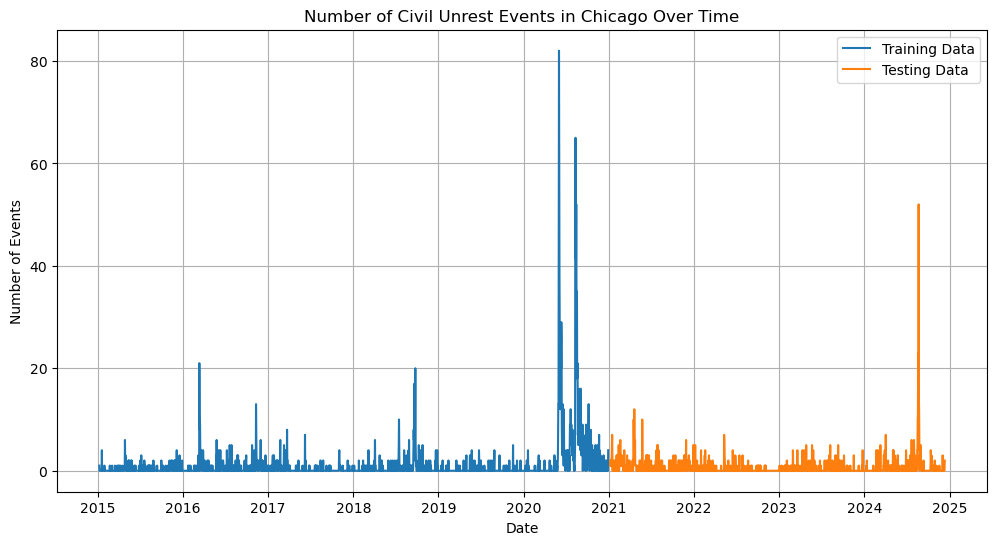

In [ ]:
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data['SQLDATE'], train_data['Number of Events'], label='Training Data')

# Plot testing data
plt.plot(test_data['SQLDATE'], test_data['Number of Events'], label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

---

## Comparisons with Research

### Let's see if these events show up in the data set

2015: Protests Following the Release of Laquan McDonald Video

In November 2015, the release of dashcam footage showing the police shooting of Laquan McDonald sparked widespread protests. Demonstrators blocked major intersections and disrupted shopping areas, leading to multiple arrests and instances of property damage. 

2020: George Floyd Protests

The death of George Floyd in May 2020 led to nationwide protests, with Chicago experiencing significant unrest. On May 31, the city recorded its deadliest day in at least 30 years, with 18 homicides within a 24-hour period. The violence coincided with protests that included rioting and looting, overwhelming the city's emergency response systems. 

2021: Protests Following the Killing of Adam Toledo

In April 2021, the police shooting of 13-year-old Adam Toledo resulted in protests throughout Chicago. While many demonstrations remained peaceful, there were instances of clashes between protesters and police, leading to arrests and injuries. 

2024: Democratic National Convention Protests

During the Democratic National Convention in August 2024, Chicago faced significant disruptions from pro-Palestinian protesters. These demonstrations led to confrontations with law enforcement and caused substantial disturbances in the city. 

These events highlight periods where protests in Chicago escalated into dangerous situations, impacting both public safety and city operations.

---

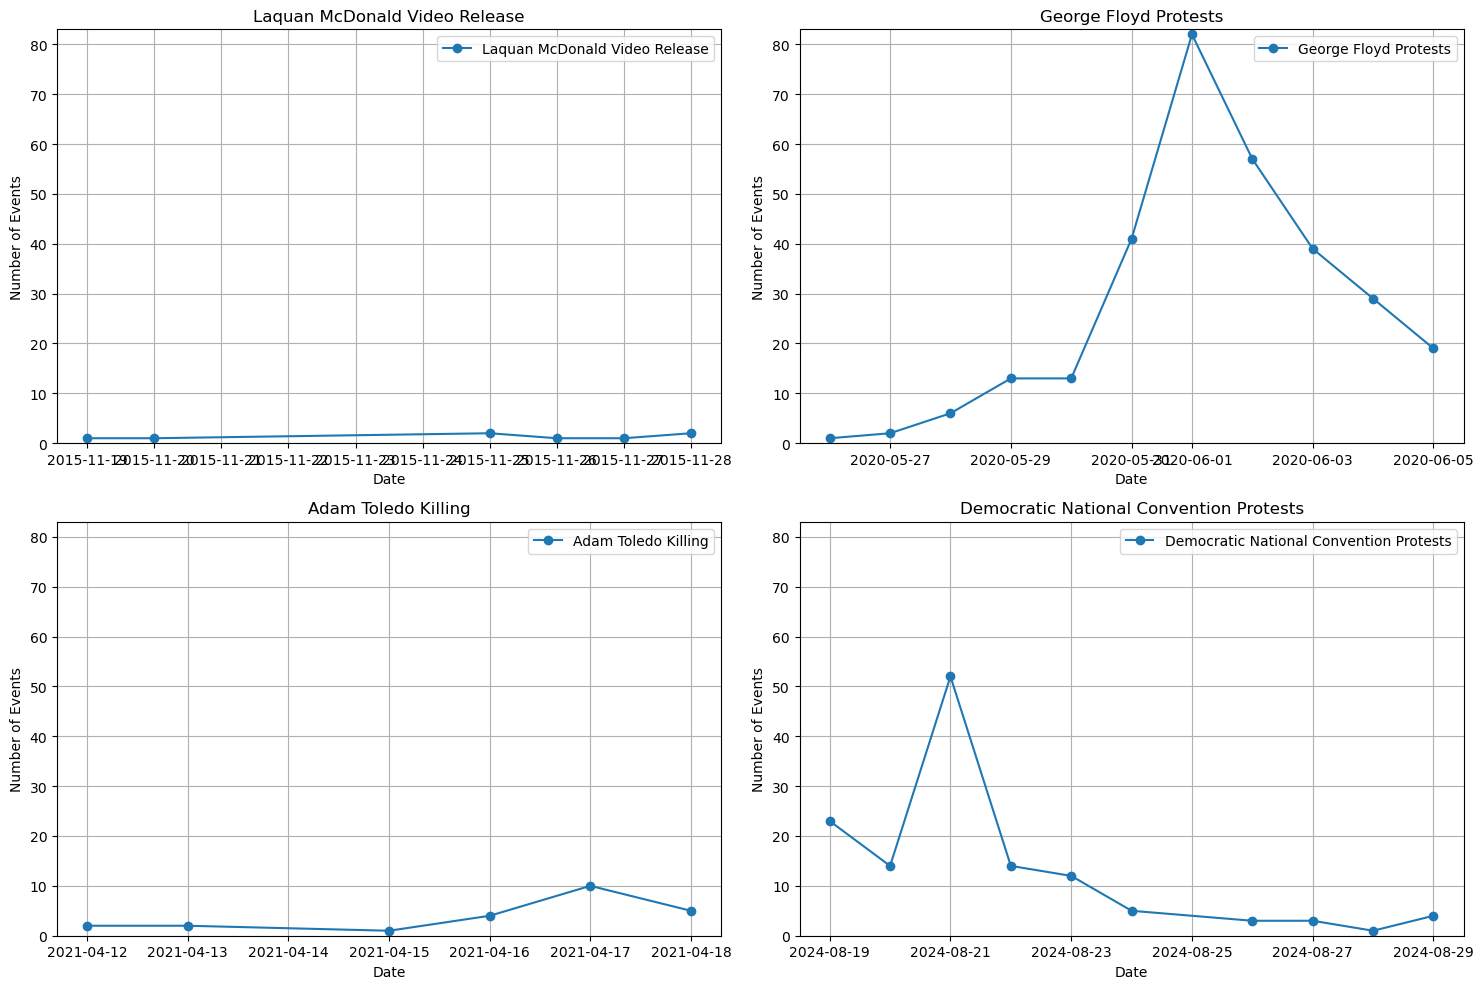

In [ ]:
# Define the specific events and their dates
events = {
    "Laquan McDonald Video Release": "2015-11-24",
    "George Floyd Protests": "2020-05-31",
    "Adam Toledo Killing": "2021-04-13",
    "Democratic National Convention Protests": "2024-08-24"
}

# Convert event dates to datetime
events = {event: pd.to_datetime(date) for event, date in events.items()}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Determine the y-axis limits based on the maximum number of events in any window
max_events = 0
for event, date in events.items():
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    max_events = max(max_events, window_data.groupby('SQLDATE').size().max())

for ax, (event, date) in zip(axes, events.items()):
    # Filter data for the 10-day window around the event
    window_data = data[(data['SQLDATE'] >= date - pd.Timedelta(days=5)) & (data['SQLDATE'] <= date + pd.Timedelta(days=5))]
    
    # Group data and ensure alignment
    grouped_data = window_data.groupby('SQLDATE').size()
    ax.plot(grouped_data.index, grouped_data.values, marker='o', label=event)
    ax.set_title(event)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Events')
    ax.set_ylim(0, max_events + 1)  # Set the same y-axis limits for all subplots
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

---

It looks like half of these events were captured. With the George Floyd and DNC events being more significant, I feel confident this data is still good; however, it'll be important to ensure the data we pulled actually is associated with the personal risk of an individual in Chicago. Seeing as the major protests of George Floyd and the DNC protests were far more signficant in nature than other protest, then I feel this is acceptable. 

We should return to see if we can naunce this further.

---